reference:https://arxiv.org/pdf/1708.05123.pdf

In [2]:
import pandas as pd
import sys

In [3]:
pd.set_option('display.max_column', 100)
pd.set_option('display.max_row', 100)

In [4]:
sys.path.append('../../../fastai/')
sys.path.append('../../')

In [5]:
# xgboost
from xgb_learn.learner import *
from xgb_learn.dataset import *
from eda.simple import *

In [6]:
# embeddings
from fastai.column_data import *
from fastai.structured import *

### Batch Outer Product

In [6]:
# bs = 5 # batch size
# p = 10 # vec dimension
# u0 = torch.ones(bs, p)

# u1 = torch.bmm(V(u0.unsqueeze(2)), V(u0.unsqueeze(1)))

# w1 = nn.Linear(p, 1).cuda()

# u1.size()

# type(w1(V(u1))), type(u0.unsqueeze(2))

# torch.add(w1(V(u1)), V(u0.unsqueeze(2)))

### EMBEDDING MODEL

In [7]:
torch.cuda.set_device(0)

In [12]:
train_small_data = pd.read_feather("../../../data/talking/train_small_data.feather")
val_small_data = pd.read_feather("../../../data/talking/val_small_data.feather")
test = pd.read_csv("../../../data/talking/test.csv")

In [13]:
# take samples from train small data and val small data
sample_ratio =  0.03
np.random.seed(7)
train_idx = np.random.choice(train_small_data.index, size=int(len(train_small_data)*sample_ratio), replace=False)
val_idx = np.random.choice(val_small_data.index, size=int(len(val_small_data)*sample_ratio), replace=False)

# create sample data
train_small_sample = train_small_data.iloc[train_idx].reset_index(drop=True, inplace=False)
val_small_sample = val_small_data.iloc[val_idx].reset_index(drop=True, inplace=False)

In [14]:
full_data = pd.read_feather("../../../data/talking/nn_small_sample_full_data.feather")

In [15]:
train_nrows, val_nrows, test_nrows =\
    train_small_sample.shape[0], val_small_sample.shape[0], test.shape[0]

In [16]:
trn_df = full_data[:train_nrows]
val_df = full_data[train_nrows:train_nrows+val_nrows]
test_df = full_data[train_nrows+val_nrows:]

In [17]:
trn_y = train_small_sample.is_attributed
val_y = val_small_sample.is_attributed # from data frames expects index 0,1, ...

In [19]:
cats = ['ip', 'app', 'device', 'os', 'channel',
'click_timeDay', 'click_timeHour']

# get cat sizes
cat_sz = [(c, len(full_data[c].unique())) for c in cats]

# create embedding sizes
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

# nconts
n_conts = len(full_data.columns) - len(cats)

In [18]:
val_df.reset_index(drop=True, inplace=True)
val_y.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [20]:
### Changed Validation Batch Size to be large enough for roc auc calculation

class ColumnarModelData(ModelData):
    def __init__(self, path, trn_ds, val_ds, bs, test_ds=None, shuffle=True):
        test_dl = DataLoader(test_ds, bs, shuffle=False, num_workers=1) if test_ds is not None else None
        super().__init__(path, DataLoader(trn_ds, bs, shuffle=shuffle, num_workers=1),
            DataLoader(val_ds, bs*10, shuffle=False, num_workers=1), test_dl) # increased validation batch size

    @classmethod
    def from_arrays(cls, path, val_idxs, xs, y, is_reg=True, is_multi=False, bs=64, test_xs=None, shuffle=True):
        ((val_xs, trn_xs), (val_y, trn_y)) = split_by_idx(val_idxs, xs, y)
        test_ds = PassthruDataset(*(test_xs.T), [0] * len(test_xs), is_reg=is_reg, is_multi=is_multi) if test_xs is not None else None
        return cls(path, PassthruDataset(*(trn_xs.T), trn_y, is_reg=is_reg, is_multi=is_multi),
                   PassthruDataset(*(val_xs.T), val_y, is_reg=is_reg, is_multi=is_multi),
                   bs=bs, shuffle=shuffle, test_ds=test_ds)

    @classmethod
    def from_data_frames(cls, path, trn_df, val_df, trn_y, val_y, cat_flds, bs, is_reg, is_multi, test_df=None):
        test_ds = ColumnarDataset.from_data_frame(test_df, cat_flds, None, is_reg, is_multi) if test_df is not None else None
        return cls(path, ColumnarDataset.from_data_frame(trn_df, cat_flds, trn_y, is_reg, is_multi),
                    ColumnarDataset.from_data_frame(val_df, cat_flds, val_y, is_reg, is_multi), bs, test_ds=test_ds)

    @classmethod
    def from_data_frame(cls, path, val_idxs, df, y, cat_flds, bs, is_reg=True, is_multi=False, test_df=None):
        ((val_df, trn_df), (val_y, trn_y)) = split_by_idx(val_idxs, df, y)
        return cls.from_data_frames(path, trn_df, val_df, trn_y, val_y, cat_flds, bs, is_reg, is_multi, test_df=test_df)

    def get_learner(self, emb_szs, n_cont, emb_drop, out_sz, szs, drops,
                    y_range=None, use_bn=False, **kwargs):
        model = MixedInputModel(emb_szs, n_cont, emb_drop, out_sz, szs, drops, y_range, use_bn, self.is_reg, self.is_multi)
        return StructuredLearner(self, StructuredModel(to_gpu(model)), opt_fn=optim.Adam, **kwargs)


### ???

In [21]:
class CrossDenseNN(nn.Module):
    #https://arxiv.org/pdf/1708.05123.pdf
    def __init__(self, emb_szs, n_cont, emb_drop, out_sz, szs, drops, cross_depth=6,
                 y_range=None, use_bn=False, is_reg=True, is_multi=False):
        super().__init__()
        self.embs = nn.ModuleList([nn.Embedding(c, s) for c,s in emb_szs])
        for emb in self.embs: emb_init(emb)
        n_emb = sum(e.embedding_dim for e in self.embs)
        self.n_emb, self.n_cont=n_emb, n_cont
        self.cross_depth = cross_depth
        # dnn layers
        szs = [n_emb+n_cont] + szs
        self.szs = szs
        self.lins = nn.ModuleList([
            nn.Linear(szs[i], szs[i+1]) for i in range(len(szs)-1)])
        self.bns = nn.ModuleList([
            nn.BatchNorm1d(sz) for sz in szs[1:]])
        for o in self.lins: kaiming_normal(o.weight.data)
        self.outp = nn.Linear(szs[-1], out_sz)
        kaiming_normal(self.outp.weight.data)

        self.emb_drop = nn.Dropout(emb_drop)
        self.drops = nn.ModuleList([nn.Dropout(drop) for drop in drops])
        self.bn = nn.BatchNorm1d(n_cont)
        self.use_bn,self.y_range = use_bn,y_range
        self.is_reg = is_reg
        self.is_multi = is_multi
        
        # cross layers
        self.lins2 = nn.ModuleList([nn.Linear(self.n_emb + self.n_cont, 1).cuda()
                      for i in range(self.cross_depth)])
        self.l_out = nn.Linear((self.n_emb + self.n_cont) + self.szs[-1], 2).cuda()

    def forward(self, x_cat, x_cont):
            
        
        if self.n_emb != 0:
            x = [e(x_cat[:,i]) for i,e in enumerate(self.embs)]
            x = torch.cat(x, 1)
            x = self.emb_drop(x)
        if self.n_cont != 0:
            x2 = self.bn(x_cont)
            x = torch.cat([x, x2], 1) if self.n_emb != 0 else x2
            
        # DNN    
        x_dnn = x
        for l,d,b in zip(self.lins, self.drops, self.bns):
            x_dnn = F.relu(l(x_dnn))
            if self.use_bn: x = b(x)
            x_dnn = d(x_dnn) 
        
        # CROSS NN
        xl = x
        x0 = x
        for l in self.lins2:
            xl = l(torch.bmm(x0.unsqueeze(2), xl.unsqueeze(1))).squeeze() + xl # bs x p 
            
            
        return F.log_softmax(self.l_out(torch.cat([x_dnn, xl], 1)))

In [22]:
# initialize model
model = CrossDenseNN(emb_szs,
                    n_cont=n_conts,
                    emb_drop=0.5,
                    out_sz=2,
                    szs=[500,500],
                    drops=[0.5, 0.5],
                    cross_depth = 4,
                    is_reg=False,
                    is_multi=False).cuda()


bm = BasicModel(model, 'binary_classifier')

# initialize model data
md = ColumnarModelData.from_data_frames('/tmp',
                                        trn_df,
                                        val_df,
                                        trn_y,
                                        val_y,
                                        cats,
                                        512, False, False, test_df=test_df)

# initialize learner
learn = StructuredLearner(md, bm)

In [18]:
learn.lr_find()

 87%|████████▋ | 1629/1872 [04:17<00:38,  6.33it/s, loss=117]    

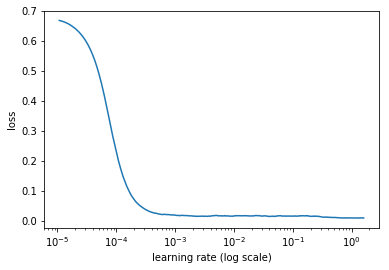

In [19]:
learn.sched.plot()

In [27]:
from sklearn.metrics import roc_auc_score

In [28]:
# auc metric
def auc(preds, targs):
    score = roc_auc_score(to_np(targs), to_np(preds)[:, 1])
    return score

In [29]:
learn.metrics = [accuracy, auc]

In [25]:
# baseline accuracy
all_zeros = 1 - val_y.mean()
all_zeros

0.9975780272115766

In [46]:
lr = 1e-2
learn.fit(lr, 20, )

  0%|          | 5/3744 [00:00<07:51,  7.92it/s, loss=0.0056] 
epoch      trn_loss   val_loss   accuracy   auc                  
    0      0.005558   0.009178   0.997343   0.95655   
    1      0.00469    0.009435   0.997454   0.955312             
    2      0.005837   0.009682   0.997101   0.955584             
    3      0.004912   0.00974    0.997337   0.954479             
    4      0.004806   0.009757   0.997424   0.953754             
 70%|██████▉   | 2611/3744 [03:06<01:21, 13.99it/s, loss=0.00431]

KeyboardInterrupt: 

 70%|██████▉   | 2611/3744 [03:20<01:26, 13.04it/s, loss=0.00431]

In [ ]:
learn.save("cross_dnn80")

In [36]:
preds = learn.predict(is_test=True)

In [38]:
is_attributed = np.exp(preds)[:, 1]

In [39]:
is_attributed[:10]

array([0.00014, 0.00021, 0.00006, 0.0004 , 0.00001, 0.00043, 0.00002, 0.00071, 0.00012, 0.00003],
      dtype=float32)

In [40]:
sub_df = pd.DataFrame({"click_id":test["click_id"], "is_attributed":is_attributed})

In [41]:
sub_df.to_csv("cross_dnn60_sub.csv", index=False)

In [43]:
FileLink("cross_dnn60_sub.csv")

/home/ec2-user/github/deeplearning/talking_data/cross_dnn60_sub.csv

In [47]:
test.head()

,click_id,ip,app,device,os,channel,click_time
0,0,5744,9,1,3,107,2017-11-10 04:00:00
1,1,119901,9,1,3,466,2017-11-10 04:00:00
2,2,72287,21,1,19,128,2017-11-10 04:00:00
3,3,78477,15,1,13,111,2017-11-10 04:00:00
4,4,123080,12,1,13,328,2017-11-10 04:00:00


In [49]:
test.sort_values(by="click_time").tail()

,click_id,ip,app,device,os,channel,click_time
18790128,18790128,84816,1,2,13,134,2017-11-10 15:00:00
18790127,18790127,95003,27,1,19,153,2017-11-10 15:00:00
18790126,18790126,45965,12,1,16,178,2017-11-10 15:00:00
18790139,18790139,14598,12,1,23,259,2017-11-10 15:00:00
18790468,18790468,73516,12,2,27,265,2017-11-10 15:00:00
